In [2]:
import pandas as pd
import os
import datetime as dt
import numpy as np
from statistics import mode
import statistics as st

pd.set_option('display.max_columns', None)
#pd.reset_option('max_columns')

In [3]:
print(os.path.abspath('.'))

C:\Users\InfiniteWing\Downloads\assignment\stock_price


In [4]:
# 匯入、合併多日資料，產生 raw_book_train、raw_raw_trade_train

train_date = ['01','02','03','07','08','09','10','13','14','15','16']
test_date = [17,20,21,22,23,24,27,28,29,30]

# train_date = ['01','02','03','07','08','09']
# test_date = [17,20,21]

# 五檔報價資料
com_train_book_data = pd.DataFrame()
for i in train_date:
    raw_data = pd.read_parquet(f'book/600519/202004{i}.parquet.gzip')
    com_train_book_data = pd.concat([com_train_book_data,raw_data])

com_test_book_data = pd.DataFrame()
for i in test_date:
    raw_data = pd.read_parquet(f'book/600519/202004{i}.parquet.gzip')
    com_test_book_data = pd.concat([com_test_book_data,raw_data])

com_train_book_data['model'] = 1
com_test_book_data['model'] = 0

raw_book_train = pd.concat([com_train_book_data, com_test_book_data])  #book_train


# 交易量資料
com_train_trade_data = pd.DataFrame()
for i in train_date:
    raw_data = pd.read_parquet(f'trade/600519/202004{i}.parquet.gzip')
    com_train_trade_data = pd.concat([com_train_trade_data,raw_data])

com_test_trade_data = pd.DataFrame()
for i in test_date:
    raw_data = pd.read_parquet(f'trade/600519/202004{i}.parquet.gzip')
    com_test_trade_data = pd.concat([com_test_trade_data,raw_data])

com_train_trade_data['model'] = 1  #訓練資料
com_test_trade_data['model'] = 0  #預測資料

com_test_trade_data['nextMidpt'] = np.nan  #要預測的值，先設None

raw_trade_train = pd.concat([com_train_trade_data, com_test_trade_data])  #trade_train

In [5]:
# data1 = pd.DataFrame({'A':pd.Series({1:1,2:2,3:3,4:4,5:5})}, columns=['A'])
# data2 = pd.DataFrame({'A':pd.Series({1:11,2:12,3:13})},columns=['A'])
# pd.concat([data1,data2])

In [6]:
## 五檔報價(特徵) -----------------------------------------------------------------------------------------
# raw_book_train = pd.read_parquet('book/600519/20200401.parquet.gzip')
book_train = raw_book_train.copy()

In [7]:
book_train['TimeStamp2'] = pd.to_datetime(book_train['TimeStamp'].values, unit='us')
book_train.head()

,TimeStamp,Bid1,Bid1Size,Ask1,Ask1Size,Bid2,Bid2Size,Ask2,Ask2Size,Bid3,Bid3Size,Ask3,Ask3Size,Bid4,Bid4Size,Ask4,Ask4Size,Bid5,Bid5Size,Ask5,Ask5Size,midpt,nextMidpt,model,TimeStamp2
index,,,,,,,,,,,,,,,,,,,,,,,,,
137,1585704603505567,1113.00,1900,1115.03,100,1112.22,2800,1116.00,500,1112.00,600,1117.0,100,1111.21,3000,1117.99,8358,1111.11,1600,1118.0,1300,1114.015,1115.265,1,2020-04-01 01:30:03.505567
138,1585704606961840,1115.03,100,1115.50,100,1114.44,200,1117.00,940,1113.01,1000,1117.1,3200,1113.00,1900,1117.40,4000,1112.22,2800,1117.5,100,1115.265,1116.495,1,2020-04-01 01:30:06.961840
139,1585704609513298,1116.00,1600,1116.99,100,1115.03,300,1117.00,1240,1114.44,200,1117.1,3200,1113.01,600,1117.40,4000,1113.00,2000,1117.5,100,1116.495,1113.795,1,2020-04-01 01:30:09.513298
140,1585704612124381,1113.15,300,1114.44,400,1113.01,600,1116.99,100,1113.00,2000,1117.1,140,1112.22,2800,1117.40,4000,1112.00,1600,1117.5,100,1113.795,1111.565,1,2020-04-01 01:30:12.124381
141,1585704615123840,1111.51,100,1111.62,2200,1111.50,200,1116.00,100,1111.30,100,1116.5,100,1111.21,3000,1117.00,300,1111.18,200,1117.4,4000,1111.565,1114.200,1,2020-04-01 01:30:15.123840


In [8]:
## 時間
book_train['Week'] = book_train['TimeStamp2'].dt.dayofweek
book_train['Hour'] = book_train['TimeStamp2'].dt.hour
book_train['Minute'] = book_train['TimeStamp2'].dt.minute
book_train['Second'] = book_train['TimeStamp2'].dt.second
book_train.head()

,TimeStamp,Bid1,Bid1Size,Ask1,Ask1Size,Bid2,Bid2Size,Ask2,Ask2Size,Bid3,Bid3Size,Ask3,Ask3Size,Bid4,Bid4Size,Ask4,Ask4Size,Bid5,Bid5Size,Ask5,Ask5Size,midpt,nextMidpt,model,TimeStamp2,Week,Hour,Minute,Second
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
137,1585704603505567,1113.00,1900,1115.03,100,1112.22,2800,1116.00,500,1112.00,600,1117.0,100,1111.21,3000,1117.99,8358,1111.11,1600,1118.0,1300,1114.015,1115.265,1,2020-04-01 01:30:03.505567,2,1,30,3
138,1585704606961840,1115.03,100,1115.50,100,1114.44,200,1117.00,940,1113.01,1000,1117.1,3200,1113.00,1900,1117.40,4000,1112.22,2800,1117.5,100,1115.265,1116.495,1,2020-04-01 01:30:06.961840,2,1,30,6
139,1585704609513298,1116.00,1600,1116.99,100,1115.03,300,1117.00,1240,1114.44,200,1117.1,3200,1113.01,600,1117.40,4000,1113.00,2000,1117.5,100,1116.495,1113.795,1,2020-04-01 01:30:09.513298,2,1,30,9
140,1585704612124381,1113.15,300,1114.44,400,1113.01,600,1116.99,100,1113.00,2000,1117.1,140,1112.22,2800,1117.40,4000,1112.00,1600,1117.5,100,1113.795,1111.565,1,2020-04-01 01:30:12.124381,2,1,30,12
141,1585704615123840,1111.51,100,1111.62,2200,1111.50,200,1116.00,100,1111.30,100,1116.5,100,1111.21,3000,1117.00,300,1111.18,200,1117.4,4000,1111.565,1114.200,1,2020-04-01 01:30:15.123840,2,1,30,15


In [9]:
book_train = book_train.reset_index()
book_train.head()

,index,TimeStamp,Bid1,Bid1Size,Ask1,Ask1Size,Bid2,Bid2Size,Ask2,Ask2Size,Bid3,Bid3Size,Ask3,Ask3Size,Bid4,Bid4Size,Ask4,Ask4Size,Bid5,Bid5Size,Ask5,Ask5Size,midpt,nextMidpt,model,TimeStamp2,Week,Hour,Minute,Second
0,137,1585704603505567,1113.00,1900,1115.03,100,1112.22,2800,1116.00,500,1112.00,600,1117.0,100,1111.21,3000,1117.99,8358,1111.11,1600,1118.0,1300,1114.015,1115.265,1,2020-04-01 01:30:03.505567,2,1,30,3
1,138,1585704606961840,1115.03,100,1115.50,100,1114.44,200,1117.00,940,1113.01,1000,1117.1,3200,1113.00,1900,1117.40,4000,1112.22,2800,1117.5,100,1115.265,1116.495,1,2020-04-01 01:30:06.961840,2,1,30,6
2,139,1585704609513298,1116.00,1600,1116.99,100,1115.03,300,1117.00,1240,1114.44,200,1117.1,3200,1113.01,600,1117.40,4000,1113.00,2000,1117.5,100,1116.495,1113.795,1,2020-04-01 01:30:09.513298,2,1,30,9
3,140,1585704612124381,1113.15,300,1114.44,400,1113.01,600,1116.99,100,1113.00,2000,1117.1,140,1112.22,2800,1117.40,4000,1112.00,1600,1117.5,100,1113.795,1111.565,1,2020-04-01 01:30:12.124381,2,1,30,12
4,141,1585704615123840,1111.51,100,1111.62,2200,1111.50,200,1116.00,100,1111.30,100,1116.5,100,1111.21,3000,1117.00,300,1111.18,200,1117.4,4000,1111.565,1114.200,1,2020-04-01 01:30:15.123840,2,1,30,15


In [10]:
%%time

col_bid_size = ['Bid1Size','Bid2Size','Bid3Size','Bid4Size','Bid5Size'] #買
col_ask_size = ['Ask1Size','Ask2Size','Ask3Size','Ask4Size','Ask5Size'] #賣

col_bid = ['Bid1','Bid2','Bid3','Bid4','Bid5'] #買
col_ask = ['Ask1','Ask2','Ask3','Ask4','Ask5'] #賣


## 動能(漲跌相對強度)
book_train['book_size_diff'] =  book_train[col_bid_size].sum(axis=1) - book_train[col_ask].sum(axis=1) #委買掛單總數-委賣掛單總數
book_train['book_size_ratio'] =  book_train[col_bid_size].sum(axis=1) / book_train[col_ask].sum(axis=1) #委買掛單總數/委賣掛單總數


## 基本描述統計值(最大、最小、平均)_ask
def get_avg1(row):
    avg = (row['Ask1Size']*row['Ask1']+row['Ask2Size']*row['Ask2']+row['Ask3Size']*row['Ask3']+row['Ask4Size']*row['Ask4']+row['Ask5Size']*row['Ask5']) / (row['Ask1Size']+row['Ask2Size']+row['Ask3Size']+row['Ask4Size']+row['Ask5Size'])
    return avg

book_train['pre_ask_min'] = book_train.shift(1)[col_ask].min(axis=1)
book_train['pre_ask_max'] = book_train.shift(1)[col_ask].max(axis=1)
book_train['pre_ask_avg'] = book_train.shift(1).apply(lambda row: get_avg1(row), axis=1)

## 基本描述統計值(眾數、四分位數)_ask 
def flatten_extend(matrix): #把巢狀lsit攤平
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

pre_book_ask_mode = []
pre_book_ask_q1 = []
pre_book_ask_q2 = []
pre_book_ask_q3 = []

for i in range(1, len(book_train)):
    term_data = []
    term_data = map( lambda x,y: book_train.loc[i-1,x].repeat(int(book_train.loc[i-1,y])) ,col_ask ,col_ask_size )
    term_data = list(term_data)
    term_data = flatten_extend(term_data)
    pre_book_ask_mode.append( mode(term_data) )
    pre_book_ask_q1.append( np.quantile(term_data,0.25) )
    pre_book_ask_q2.append( np.quantile(term_data,0.5) )
    pre_book_ask_q3.append( np.quantile(term_data,0.75) )

pre_book_ask_mode.insert( 0, pre_book_ask_mode[0] )
pre_book_ask_q1.insert( 0, pre_book_ask_q1[0] )
pre_book_ask_q2.insert( 0, pre_book_ask_q2[0] )
pre_book_ask_q3.insert( 0, pre_book_ask_q3[0] )

book_train['pre_book_ask_mode'] = pre_book_ask_mode
book_train['pre_book_ask_q1'] = pre_book_ask_q1
book_train['pre_book_ask_q2'] = pre_book_ask_q2
book_train['pre_book_ask_q3'] = pre_book_ask_q3

book_train.head()

KeyboardInterrupt: 

In [11]:
%%time

## 基本描述統計值(最大、最小、平均)_bid
def get_avg2(row):
    avg = (row['Bid1Size']*row['Bid1']+row['Bid2Size']*row['Bid2']+row['Bid3Size']*row['Bid3']+row['Bid4Size']*row['Bid4']+row['Bid5Size']*row['Bid5']) / (row['Bid1Size']+row['Bid2Size']+row['Bid3Size']+row['Bid4Size']+row['Bid5Size'])
    return avg

book_train['pre_bid_min'] = book_train.shift(1)[col_bid].min(axis=1)
book_train['pre_bid_max'] = book_train.shift(1)[col_bid].max(axis=1)
book_train['pre_bid_avg'] = book_train.shift(1).apply(lambda row: get_avg2(row), axis=1)

## 基本描述統計值(眾數、四分位數)_bid
pre_book_bid_mode = []
pre_book_bid_q1 = []
pre_book_bid_q2 = []
pre_book_bid_q3 = []

for i in range(1, len(book_train)):
    term_data = []
    term_data = map(lambda x,y: book_train.loc[i-1,x].repeat(int(book_train.loc[i-1,y])) ,col_bid ,col_bid_size )
    term_data = list(term_data)
    term_data = flatten_extend(term_data)
    pre_book_bid_mode.append( mode(term_data) )
    pre_book_bid_q1.append( np.quantile(term_data,0.25) )
    pre_book_bid_q2.append( np.quantile(term_data,0.5) )
    pre_book_bid_q3.append( np.quantile(term_data,0.75) )

pre_book_bid_mode.insert( 0, pre_book_bid_mode[0] )
pre_book_bid_q1.insert( 0, pre_book_bid_q1[0] )
pre_book_bid_q2.insert( 0, pre_book_bid_q2[0] )
pre_book_bid_q3.insert( 0, pre_book_bid_q3[0] )

book_train['pre_book_bid_mode'] = pre_book_bid_mode
book_train['pre_book_bid_q1'] = pre_book_bid_q1
book_train['pre_book_bid_q2'] = pre_book_bid_q2
book_train['pre_book_bid_q3'] = pre_book_bid_q3

book_train.head()


KeyboardInterrupt



In [12]:
## 移動平均線
book_train['book_ma_6s'] =  book_train['midpt'].shift(1).rolling(1).mean()
book_train['book_ma_12s'] = book_train['midpt'].shift(1).rolling(2).mean()
book_train['book_ma_24s'] = book_train['midpt'].shift(1).rolling(3).mean()
book_train['book_ma_48s'] = book_train['midpt'].shift(1).rolling(4).mean()
book_train['book_ma_96s'] = book_train['midpt'].shift(1).rolling(5).mean()

book_train['book_mstd_12s'] = book_train['midpt'].shift(1).rolling(2).std()
book_train['book_mstd_24s'] = book_train['midpt'].shift(1).rolling(3).std()
book_train['book_mstd_48s'] = book_train['midpt'].shift(1).rolling(4).std()
book_train['book_mstd_96s'] = book_train['midpt'].shift(1).rolling(5).std()

book_train.head(10)

,index,TimeStamp,Bid1,Bid1Size,Ask1,Ask1Size,Bid2,Bid2Size,Ask2,Ask2Size,Bid3,Bid3Size,Ask3,Ask3Size,Bid4,Bid4Size,Ask4,Ask4Size,Bid5,Bid5Size,Ask5,Ask5Size,midpt,nextMidpt,model,TimeStamp2,Week,Hour,Minute,Second,book_size_diff,book_size_ratio,pre_ask_min,pre_ask_max,pre_ask_avg,pre_bid_min,pre_bid_max,book_ma_6s,book_ma_12s,book_ma_24s,book_ma_48s,book_ma_96s,book_mstd_12s,book_mstd_24s,book_mstd_48s,book_mstd_96s
0,137,1585704603505567,1113.00,1900,1115.03,100,1112.22,2800,1116.00,500,1112.00,600,1117.00,100,1111.21,3000,1117.99,8358,1111.11,1600,1118.00,1300,1114.015,1115.265,1,2020-04-01 01:30:03.505567,2,1,30,3,4315.98,1.772916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,138,1585704606961840,1115.03,100,1115.50,100,1114.44,200,1117.00,940,1113.01,1000,1117.10,3200,1113.00,1900,1117.40,4000,1112.22,2800,1117.50,100,1115.265,1116.495,1,2020-04-01 01:30:06.961840,2,1,30,6,415.50,1.074402,1115.03,1118.00,1117.857059,1111.11,1113.00,1114.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,139,1585704609513298,1116.00,1600,1116.99,100,1115.03,300,1117.00,1240,1114.44,200,1117.10,3200,1113.01,600,1117.40,4000,1113.00,2000,1117.50,100,1116.495,1113.795,1,2020-04-01 01:30:09.513298,2,1,30,9,-885.99,0.841391,1115.50,1117.50,1117.218225,1112.22,1115.03,1115.265,1114.6400,NaN,NaN,NaN,0.883883,NaN,NaN,NaN
3,140,1585704612124381,1113.15,300,1114.44,400,1113.01,600,1116.99,100,1113.00,2000,1117.10,140,1112.22,2800,1117.40,4000,1112.00,1600,1117.50,100,1113.795,1111.565,1,2020-04-01 01:30:12.124381,2,1,30,12,1716.57,1.307440,1116.99,1117.50,1117.227894,1113.00,1116.00,1116.495,1115.8800,1115.258333,NaN,NaN,0.869741,1.240013,NaN,NaN
4,141,1585704615123840,1111.51,100,1111.62,2200,1111.50,200,1116.00,100,1111.30,100,1116.50,100,1111.21,3000,1117.00,300,1111.18,200,1117.40,4000,1111.565,1114.200,1,2020-04-01 01:30:15.123840,2,1,30,15,-1978.52,0.645332,1114.44,1117.50,1117.134810,1112.00,1113.15,1113.795,1115.1450,1115.185000,1114.89250,NaN,1.909188,1.351777,1.249170,NaN
5,142,1585704618121704,1111.00,2200,1117.40,4100,1110.90,2100,1117.50,100,1110.02,100,1117.51,100,1110.01,200,1117.60,15000,1110.00,2000,1117.99,7758,1114.200,1111.895,1,2020-04-01 01:30:18.121704,2,1,30,18,1012.00,1.181102,1111.62,1117.40,1115.449851,1111.18,1111.51,1111.565,1112.6800,1113.951667,1114.28000,1114.227,1.576848,2.468731,2.119976,1.839774
6,143,1585704621132090,1111.51,100,1112.28,100,1111.00,2700,1115.50,100,1110.90,2100,1115.76,200,1110.02,100,1116.79,100,1110.01,200,1117.39,1100,1111.895,1111.115,1,2020-04-01 01:30:21.132090,2,1,30,21,-377.72,0.932281,1117.40,1117.99,1117.680812,1110.00,1111.00,1114.200,1112.8825,1113.186667,1114.01375,1114.264,1.863226,1.418929,2.019531,1.836302
7,144,1585704624123763,1111.11,300,1111.12,1000,1111.00,2700,1112.28,200,1110.90,2100,1115.50,200,1110.02,100,1115.76,200,1110.01,200,1116.79,100,1111.115,1113.890,1,2020-04-01 01:30:24.123763,2,1,30,24,-171.45,0.969227,1112.28,1117.39,1116.711250,1110.01,1111.51,1111.895,1113.0475,1112.553333,1112.86375,1113.590,1.629881,1.435569,1.326401,1.989146
8,145,1585704627126163,1112.28,2900,1115.50,200,1111.12,100,1115.76,200,1111.11,300,1116.49,200,1111.03,500,1116.79,100,1111.01,100,1117.30,100,1113.890,1113.640,1,2020-04-01 01:30:27.126163,2,1,30,27,-1681.84,0.698694,1111.12,1116.79,1112.651176,1110.01,1111.11,1111.115,1111.5050,1112.403333,1112.19375,1112.514,0.551543,1.604091,1.375175,1.389651
9,146,1585704630122292,1112.28,3300,1115.00,300,1111.22,1000,1115.49,1100,1111.13,500,1115.50,400,1111.12,100,1115.76,200,1111.11,1300,1116.49,300,1113.640,1114.320,1,2020-04-01 01:30:30.122292,2,1,30,30,621.76,1.111462,1115.50,1117.30,1116.198750,1111.01,1112.28,1113.890,1112.5025,1112.300000,1112.77500,1112.533,1.962221,1.431145,1.505971,1.412014


In [13]:
# 加上'ts_id'作為和trade data mapping用
book_train['ts_id'] = range(0,len(book_train),1)

In [14]:
book_train.head()

,index,TimeStamp,Bid1,Bid1Size,Ask1,Ask1Size,Bid2,Bid2Size,Ask2,Ask2Size,Bid3,Bid3Size,Ask3,Ask3Size,Bid4,Bid4Size,Ask4,Ask4Size,Bid5,Bid5Size,Ask5,Ask5Size,midpt,nextMidpt,model,TimeStamp2,Week,Hour,Minute,Second,book_size_diff,book_size_ratio,pre_ask_min,pre_ask_max,pre_ask_avg,pre_bid_min,pre_bid_max,book_ma_6s,book_ma_12s,book_ma_24s,book_ma_48s,book_ma_96s,book_mstd_12s,book_mstd_24s,book_mstd_48s,book_mstd_96s,ts_id
0,137,1585704603505567,1113.00,1900,1115.03,100,1112.22,2800,1116.00,500,1112.00,600,1117.0,100,1111.21,3000,1117.99,8358,1111.11,1600,1118.0,1300,1114.015,1115.265,1,2020-04-01 01:30:03.505567,2,1,30,3,4315.98,1.772916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,138,1585704606961840,1115.03,100,1115.50,100,1114.44,200,1117.00,940,1113.01,1000,1117.1,3200,1113.00,1900,1117.40,4000,1112.22,2800,1117.5,100,1115.265,1116.495,1,2020-04-01 01:30:06.961840,2,1,30,6,415.50,1.074402,1115.03,1118.0,1117.857059,1111.11,1113.00,1114.015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,139,1585704609513298,1116.00,1600,1116.99,100,1115.03,300,1117.00,1240,1114.44,200,1117.1,3200,1113.01,600,1117.40,4000,1113.00,2000,1117.5,100,1116.495,1113.795,1,2020-04-01 01:30:09.513298,2,1,30,9,-885.99,0.841391,1115.50,1117.5,1117.218225,1112.22,1115.03,1115.265,1114.640,NaN,NaN,NaN,0.883883,NaN,NaN,NaN,2
3,140,1585704612124381,1113.15,300,1114.44,400,1113.01,600,1116.99,100,1113.00,2000,1117.1,140,1112.22,2800,1117.40,4000,1112.00,1600,1117.5,100,1113.795,1111.565,1,2020-04-01 01:30:12.124381,2,1,30,12,1716.57,1.307440,1116.99,1117.5,1117.227894,1113.00,1116.00,1116.495,1115.880,1115.258333,NaN,NaN,0.869741,1.240013,NaN,NaN,3
4,141,1585704615123840,1111.51,100,1111.62,2200,1111.50,200,1116.00,100,1111.30,100,1116.5,100,1111.21,3000,1117.00,300,1111.18,200,1117.4,4000,1111.565,1114.200,1,2020-04-01 01:30:15.123840,2,1,30,15,-1978.52,0.645332,1114.44,1117.5,1117.134810,1112.00,1113.15,1113.795,1115.145,1115.185000,1114.8925,NaN,1.909188,1.351777,1.24917,NaN,4


In [15]:
## 交易量(特徵) -----------------------------------------------------------------------------------------
raw_trade_train = pd.read_parquet('trade/600519/20200401.parquet.gzip')
trade_train = raw_trade_train.copy()

In [16]:
trade_train['TimeStamp2'] = pd.to_datetime(trade_train['TimeStamp'].values, unit='us')
trade_train.head()

,TimeStamp,BidID,AskID,BuyVolume,BuyPrice,SellVolume,SellPrice,TimeStamp2
index,,,,,,,,
213,1585704600549504,99924,141932,0,0.0,100,1115.5,2020-04-01 01:30:00.549504
214,1585704600551309,142138,141795,100,1116.0,0,0.0,2020-04-01 01:30:00.551309
215,1585704601244086,86301,142421,0,0.0,100,1115.0,2020-04-01 01:30:01.244086
216,1585704601252795,141888,143205,0,0.0,100,1115.0,2020-04-01 01:30:01.252795
217,1585704601256878,141888,143923,0,0.0,200,1115.0,2020-04-01 01:30:01.256878


In [17]:
## 時間
trade_train['Week'] = trade_train['TimeStamp2'].dt.dayofweek
trade_train['Hour'] = trade_train['TimeStamp2'].dt.hour
trade_train['Minute'] = trade_train['TimeStamp2'].dt.minute
trade_train['Second'] = trade_train['TimeStamp2'].dt.second
trade_train.head()

,TimeStamp,BidID,AskID,BuyVolume,BuyPrice,SellVolume,SellPrice,TimeStamp2,Week,Hour,Minute,Second
index,,,,,,,,,,,,
213,1585704600549504,99924,141932,0,0.0,100,1115.5,2020-04-01 01:30:00.549504,2,1,30,0
214,1585704600551309,142138,141795,100,1116.0,0,0.0,2020-04-01 01:30:00.551309,2,1,30,0
215,1585704601244086,86301,142421,0,0.0,100,1115.0,2020-04-01 01:30:01.244086,2,1,30,1
216,1585704601252795,141888,143205,0,0.0,100,1115.0,2020-04-01 01:30:01.252795,2,1,30,1
217,1585704601256878,141888,143923,0,0.0,200,1115.0,2020-04-01 01:30:01.256878,2,1,30,1


In [18]:
# 交易量對應五檔報價"ts_id"

tstotsid_ = dict(zip(book_train['TimeStamp'].values, book_train['ts_id'].values))
# tstotsid_
# tstotsid_[1585704621132090]

import bisect
book_ts = book_train['TimeStamp'].values.tolist()  #dataframe to list

def get_ts_id(ts):  #ts: timestamp
    index_to_insert = bisect.bisect_left(book_ts, ts)  #回傳插入的位置，以0開頭
    try:
        return tstotsid_[book_ts[index_to_insert]]  #回傳對應的ts_id
    except:
        return -1
    
trade_train['ts_id'] = trade_train['TimeStamp'].apply(lambda ts: get_ts_id(ts))  #ts:trade每一列
trade_train.query('ts_id == -1')

KeyboardInterrupt: 

In [18]:
# list_ = [10003, 10006, 10009, 10012, 10015, 10018]
# #index  0       1     2        3    4      5

# number = 10005
# index_to_insert = bisect.bisect_left(list_, number)
# print(f"need to insert {number} at {index_to_insert}")
# print(f"value at index {index_to_insert} is {list_[index_to_insert]}")
# # index = 1, insert 10006
# list_.insert(index_to_insert, number)
# list_

In [ ]:
# 交易買賣差、交易買賣比
dict_tmp = (trade_train.groupby('ts_id')['SellVolume'].sum() - trade_train.groupby('ts_id')['BuyVolume'].sum()).to_dict()
trade_train['trade_size_diff'] = trade_train['ts_id'].map(dict_tmp)

dict_tmp = (trade_train.groupby('ts_id')['SellVolume'].sum() / trade_train.groupby('ts_id')['BuyVolume'].sum()).to_dict()
trade_train['trade_size_ratio'] = trade_train['ts_id'].map(dict_tmp)

trade_train.head()

In [20]:
# 買、賣 各成交總次數
df_result = trade_train.groupby(trade_train['ts_id'])['BuyVolume'].agg(lambda x: x[x>0].count()).reset_index()
df_result = df_result.rename(columns={'BuyVolume':'trade_buy_cnt'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.groupby(trade_train['ts_id'])['SellVolume'].agg(lambda x: x[x>0].count()).reset_index()
df_result = df_result.rename(columns={'SellVolume': 'trade_sell_cnt'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

trade_train['trade_cnt_diff'] = trade_train['trade_sell_cnt'] - trade_train['trade_buy_cnt'] #買成 > 賣成，預期價格跌。
trade_train.head()

,TimeStamp,BidID,AskID,BuyVolume,BuyPrice,SellVolume,SellPrice,TimeStamp2,Week,Hour,Minute,Second,ts_id,trade_size_diff,trade_size_ratio,trade_buy_cnt,trade_sell_cnt,trade_cnt_diff
0,1585704600549504,99924,141932,0,0.0,100,1115.5,2020-04-01 01:30:00.549504,2,1,30,0,0,2500,5.166667,6,8,2
1,1585704600551309,142138,141795,100,1116.0,0,0.0,2020-04-01 01:30:00.551309,2,1,30,0,0,2500,5.166667,6,8,2
2,1585704601244086,86301,142421,0,0.0,100,1115.0,2020-04-01 01:30:01.244086,2,1,30,1,0,2500,5.166667,6,8,2
3,1585704601252795,141888,143205,0,0.0,100,1115.0,2020-04-01 01:30:01.252795,2,1,30,1,0,2500,5.166667,6,8,2
4,1585704601256878,141888,143923,0,0.0,200,1115.0,2020-04-01 01:30:01.256878,2,1,30,1,0,2500,5.166667,6,8,2


In [ ]:
# 內/外盤成交價(sell,buy)移動平均線、移動標準差
#sell
df_result = trade_train.query('SellPrice > 0').groupby('ts_id')['SellPrice'].rolling(1).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'SellPrice':'sell_ma1'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('SellPrice > 0').groupby('ts_id')['SellPrice'].rolling(3).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'SellPrice':'sell_ma3'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('SellPrice > 0').groupby('ts_id')['SellPrice'].rolling(6).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'SellPrice':'sell_ma6'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('SellPrice > 0').groupby('ts_id')['SellPrice'].rolling(3).std().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'SellPrice':'sell_mstd3'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('SellPrice > 0').groupby('ts_id')['SellPrice'].rolling(6).std().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'SellPrice':'sell_mstd6'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

#buy
df_result = trade_train.query('BuyPrice > 0').groupby('ts_id')['BuyPrice'].rolling(1).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'BuyPrice':'buyl_ma1'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('BuyPrice > 0').groupby('ts_id')['BuyPrice'].rolling(3).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'BuyPrice':'buyl_ma3'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('BuyPrice > 0').groupby('ts_id')['BuyPrice'].rolling(6).mean().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'BuyPrice':'buyl_ma6'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('BuyPrice > 0').groupby('ts_id')['BuyPrice'].rolling(3).std().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'BuyPrice':'buyl_mstd3'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

df_result = trade_train.query('BuyPrice > 0').groupby('ts_id')['BuyPrice'].rolling(6).std().reset_index()
df_result = df_result.drop_duplicates('ts_id', keep='last').drop(columns=['level_1'])
df_result = df_result.rename(columns={'BuyPrice':'buyl_mstd6'})
trade_train = trade_train.merge(df_result, how='inner', on='ts_id')

trade_train.head()

In [22]:
# ts2buyprice = {}

# for i, row in trade_train.iterrows():  #iterrows
#     ts = row['ts_id']
#     buyvolume = row['BuyVolume']
#     buyprice = row['BuyPrice']
#     if ts not in ts2buyprice:
#         ts2buyprice[ts] = []
#     for j in range(buyvolume // 100):
#         ts2buyprice[ts].append(buyprice)

# ts2buypriceq25 = {}
# for key, value in ts2buyprice.items():
#     value = sorted(value)
#     if (len(value) > 0):
#         ts2buypriceq25[key] = np.percentile(np.array(value), 25)

In [ ]:
# 描述性統計: 前一個時段所有內/外盤成交的 (最大、最小、平均數、四分位數、眾數)
# %%time

#最大、最小
dict_tmp = trade_train.groupby('ts_id')['BuyPrice'].max().to_dict()
trade_train['buy_max'] = trade_train['ts_id'].map(dict_tmp)

dict_tmp = trade_train.groupby('ts_id')['BuyPrice'].agg(lambda x: x[x>0].min()).to_dict()
trade_train['buy_min'] = trade_train['ts_id'].map(dict_tmp)

#平均數、四分位數、眾數
pre_buy_q1 = {}
pre_buy_q2 = {}
pre_buy_q3 = {}
pre_buy_avg = {}
pre_buy_mode = {}

for tsid in trade_train['ts_id'].unique():
    split_data = trade_train.query(f'ts_id == {tsid}')
    split_data = split_data.query('BuyVolume > 0').reset_index()
    
    term_data2=[]
    data_q1=[]
    data_q2=[]
    data_q3=[]
    data_avg=[]
    data_mode=[]
    
    for i in range(0,len(split_data)):
        term_data1 = []
        term_data1 = split_data.loc[i,'BuyPrice'].repeat(int(split_data.loc[i,'BuyVolume']//100))
        term_data1 = term_data1.tolist()
        term_data2 += term_data1
    
    if len(term_data2) > 0:
        data_q1 = np.quantile(term_data2, 0.25)
        data_q2 = np.quantile(term_data2, 0.5)
        data_q3 = np.quantile(term_data2, 0.75)
        data_avg = np.mean(term_data2)
        data_mode = mode(term_data2)
              
        pre_buy_q1[tsid] = data_q1
        pre_buy_q2[tsid] = data_q2
        pre_buy_q3[tsid] = data_q3
        pre_buy_avg[tsid] = data_avg
        pre_buy_mode[tsid] = data_mode
    
    else: 
        pre_buy_q1[tsid] = None
        pre_buy_q2[tsid] = None
        pre_buy_q3[tsid] = None
        pre_buy_avg[tsid] = None
        pre_buy_mode[tsid] = None
        
trade_train['pre_buy_q1'] = trade_train['ts_id'].map(pre_buy_q1)
trade_train['pre_buy_q2'] = trade_train['ts_id'].map(pre_buy_q2)
trade_train['pre_buy_q3'] = trade_train['ts_id'].map(pre_buy_q3)
trade_train['pre_buy_avg'] = trade_train['ts_id'].map(pre_buy_avg)
trade_train['pre_buy_mode'] = trade_train['ts_id'].map(pre_buy_mode)

trade_train.head()

In [ ]:
# 描述性統計: 前一個時段所有內/外盤成交的 (最大、最小、平均數、四分位數、眾數)
#%%time

# 最大、最小
dict_tmp = trade_train.groupby('ts_id')['SellPrice'].max().to_dict()
trade_train['sell_max'] = trade_train['ts_id'].map(dict_tmp)

dict_tmp = trade_train.groupby('ts_id')['SellPrice'].agg(lambda x: x[x>0].min()).to_dict()
trade_train['sell_min'] = trade_train['ts_id'].map(dict_tmp)

# 平均數、四分位數、眾數
pre_sell_q1 = {}
pre_sell_q2 = {}
pre_sell_q3 = {}
pre_sell_avg = {}
pre_sell_mode = {}

for tsid in trade_train['ts_id'].unique():
    split_data = trade_train.query(f'ts_id == {tsid}')
    split_data = split_data.query('SellVolume > 0').reset_index()
    
    term_data2=[]
    data_q1=[]
    data_q2=[]
    data_q3=[]
    data_avg=[]
    data_mode=[]
    
    for i in range(0,len(split_data)):
        term_data1 = []
        term_data1 = split_data.loc[i,'SellPrice'].repeat(int(split_data.loc[i,'SellVolume']//100))
        term_data1 = term_data1.tolist()
        term_data2 += term_data1
    
    if len(term_data2) > 0:
        data_q1 = np.quantile(term_data2, 0.25)
        data_q2 = np.quantile(term_data2, 0.5)
        data_q3 = np.quantile(term_data2, 0.75)
        data_avg = np.mean(term_data2)
        data_mode = mode(term_data2)
              
        pre_sell_q1[tsid] = data_q1
        pre_sell_q2[tsid] = data_q2
        pre_sell_q3[tsid] = data_q3
        pre_sell_avg[tsid] = data_avg
        pre_sell_mode[tsid] = data_mode
    
    else: 
        pre_sell_q1[tsid] = None
        pre_sell_q2[tsid] = None
        pre_sell_q3[tsid] = None
        pre_sell_avg[tsid] = None
        pre_sell_mode[tsid] = None
        
trade_train['pre_sell_q1'] = trade_train['ts_id'].map(pre_sell_q1)
trade_train['pre_sell_q2'] = trade_train['ts_id'].map(pre_sell_q2)
trade_train['pre_sell_q3'] = trade_train['ts_id'].map(pre_sell_q3)
trade_train['pre_sell_avg'] = trade_train['ts_id'].map(pre_sell_avg)
trade_train['pre_sell_mode'] = trade_train['ts_id'].map(pre_sell_mode)

trade_train.head()

In [ ]:
#將五檔報價資料 和 成交量 資料結合，產生feature_data
feature_data = book_train.copy()

col_position = [i for i in range(12,41,1)]
col_position
trade_train_merge = trade_train.iloc[:, col_position].drop_duplicates()

feature_data = feature_data.merge(trade_train_merge, how='left', on='ts_id')

feature_data.head()

In [ ]:
feature_data['ts_id'].nunique()  

In [ ]:
# 處理nan值
#pd.set_option('display.max_rows', 500) #大部分五檔報價沒有對應到交易量
#pd.set_option('display.max_rows', 10)
print(feature_data.isna().sum())

In [ ]:
#將na值填為-1
feature_data = feature_data.fillna(-1)
feature_data.head()

In [ ]:
#刪除不需要的欄位
drop_column = ['index','TimeStamp','TimeStamp2']
feature_data = feature_data.drop(columns = drop_column)
feature_data.head()

In [30]:
feature_data.to_csv('feature_data.csv', index = False)

In [30]:
feature_data = pd.read_csv('feature_data.csv')
feature_data.head()

feature_data = feature_data.drop(columns=['Week','Hour','Minute','Second','ts_id'])

In [95]:
# 模型預測 (delta調整 -> 在tree model有效果)
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

# 1.資料分為train、test
x_train = feature_data.query('model==1 and nextMidpt > 0').copy()
y_train_real = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']
x_test = feature_data.query('model==0 and nextMidpt > 0').copy()
y_test_real = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']

# 計算delta
x_train['nextMidpt_delta'] = x_train['nextMidpt'] - x_train['midpt']
x_test['nextMidpt_delta'] = x_test['nextMidpt'] - x_test['midpt']
y_train = x_train['nextMidpt_delta'].values
y_test = x_test['nextMidpt_delta'].values

test_midpt = x_test['midpt'].values

# 標準化
all_columns = x_train.columns
scaler = minmax.fit(x_train[all_columns])
x_train[all_columns] = scaler.transform(x_train[all_columns])
x_test[all_columns] = scaler.transform(x_test[all_columns])

# 移除欄位
x_train = x_train.drop(columns='nextMidpt')
x_train = x_train.drop(columns = 'model')
x_train = x_train.drop(columns='nextMidpt_delta')
x_test = x_test.drop(columns='nextMidpt')
x_test = x_test.drop(columns='nextMidpt_delta')
x_test = x_test.drop(columns = 'model')

# 預測
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

# 計算RMSE
MSE = mean_squared_error(y_test_real, y_pred + test_midpt)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

In [74]:
# 模型預測
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

# 1.資料分為train、test
x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

x_test = feature_data.query('model==0 and nextMidpt > 0').drop(columns='nextMidpt') 
y_test = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']

#正規化
all_columns = x_train.columns
scaler = minmax.fit(x_train[all_columns])
x_train[all_columns] = scaler.transform(x_train[all_columns])
x_train = x_train.drop(columns = 'model')

x_test[all_columns] = scaler.transform(x_test[all_columns])
x_test = x_test.drop(columns = 'model')

'learning rate': [0.1, 0.01, 0.03]
model 1: 0.1 (99), 0.01 (121), 0.03(133)
model 2: 0.1 (199), 0.01 (121), 0.03(133)
model 3: 0.1 (99), 0.01 (71), 0.03(133)
model 4: 0.1 (99), 0.01 (121), 0.03(133)
model 5: 0.1 (99), 0.01 (121), 0.03(86)

In [35]:
# 2.調教模型超參數
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

import math

def hyperparameter_tuning(x_train, y_train):
    
    param_grid = {'learning rate': [0.1, 0.01, 0.03],
                 'max_depth': [5],
                 'min_child_weight': [3],
                 'subsample': [0.7],
                  'colsample_bytree': [0.7],
                  'n_estimators' : [100, 200, 500],  #number of tree
                  'objective': ['reg:squarederror']}  #loss function
    
    estimator = XGBRegressor()
    
    gsearch = GridSearchCV(estimator = estimator,
                           param_grid = param_grid,
                           scoring = 'neg_root_mean_squared_error',  #RMSE  #https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
                           cv = 5,)
    
    gsearch = gsearch.fit(x_train, y_train)
    
    return gsearch.best_params_

hyperparameter_tuning(x_train,y_train)

ValueError: 
All the 45 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [16:11:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:749: Invalid parameter "learning rate" contains whitespace.

--------------------------------------------------------------------------------
19 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [16:11:24] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:749: Invalid parameter "learning rate" contains whitespace.

--------------------------------------------------------------------------------
13 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py", line 1025, in fit
    self._Booster = train(
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\training.py", line 185, in train
    bst.update(dtrain, i, obj)
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 1918, in update
    _check_call(_LIB.XGBoosterUpdateOneIter(self.handle,
  File "C:\Users\InfiniteWing\miniconda3\envs\myenv\lib\site-packages\xgboost\core.py", line 279, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: [16:11:25] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:749: Invalid parameter "learning rate" contains whitespace.


In [93]:
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

# 3.最佳模型預測
xgb_model = XGBRegressor( objective = 'reg:squarederror',
                       colsample_bytree = 0.8,
                       learning_rate = 0.01,
                       max_depth = 5,
                       min_child_weight = 1,
                       n_estimators = 500,
                       subsample = 0.8 )

xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_test)


# 4.計算RMSE
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)


# 4.計算RMSE (因為有delta，要嘉回去)
MSE = mean_squared_error(y_test_real, y_pred+test_midpt)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 0.30828612948812806
Root Mean Square Error: 0.30828612948812806


In [88]:
y_test

array([-1.005,  0.42 , -0.005, ...,  0.   ,  0.095,  0.005])

In [76]:
## 用linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)


# 4.計算RMSE
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 0.2512500609305317


In [43]:
0.2512500609305317/0.2513284935798189

0.9996879277467905

In [151]:
# 檢視特徵表現：
# (1)coefficient
importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': reg.coef_
})
importances = importances.sort_values(by='Importance', ascending=False)

pd.set_option('display.max_rows', None)
importances

,Attribute,Importance
2,Ask1,6.489153e+07
0,Bid1,6.177591e+07
6,Ask2,3.115628e+06
18,Ask5,3.115628e+06
10,Ask3,3.115628e+06
14,Ask4,3.115628e+06
26,book_size_diff,3.115628e+06
42,book_ma_6s,1.592276e+06
55,trade_sell_cnt,1.375049e+00
72,pre_buy_avg,5.556852e-01


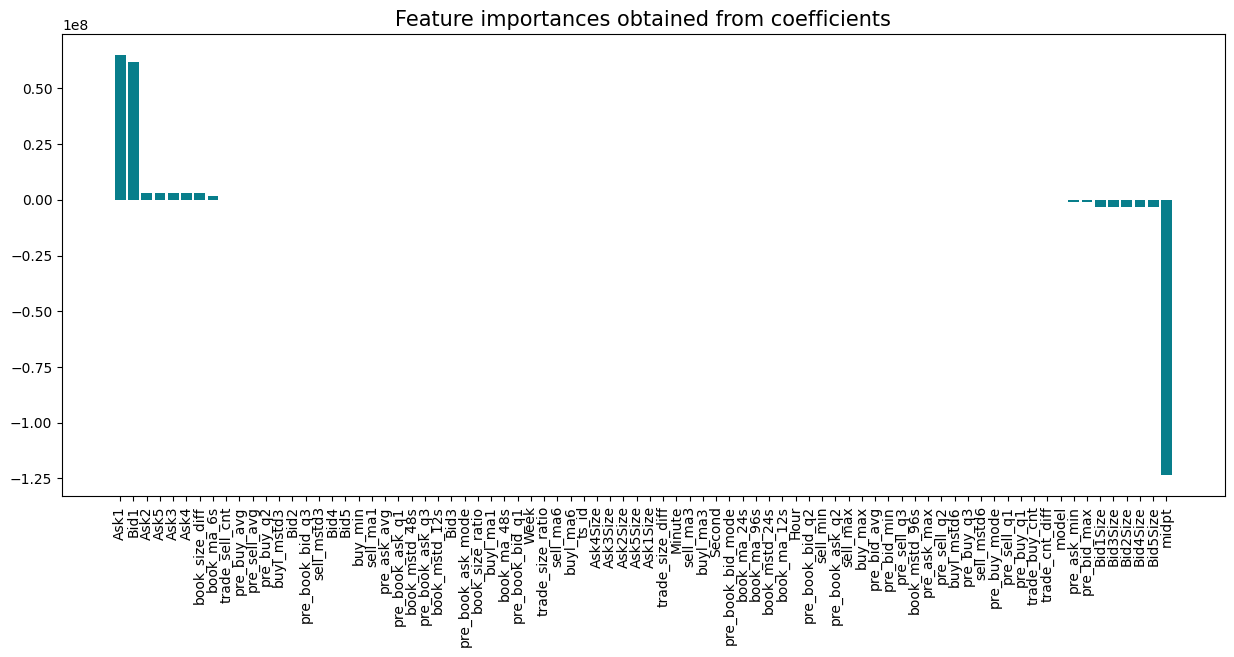

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=15)
plt.xticks(rotation='vertical')
plt.show()

In [39]:
# (2) sharp relation
mport shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [40]:
explainer = shap.LinearExplainer(reg, x_train)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


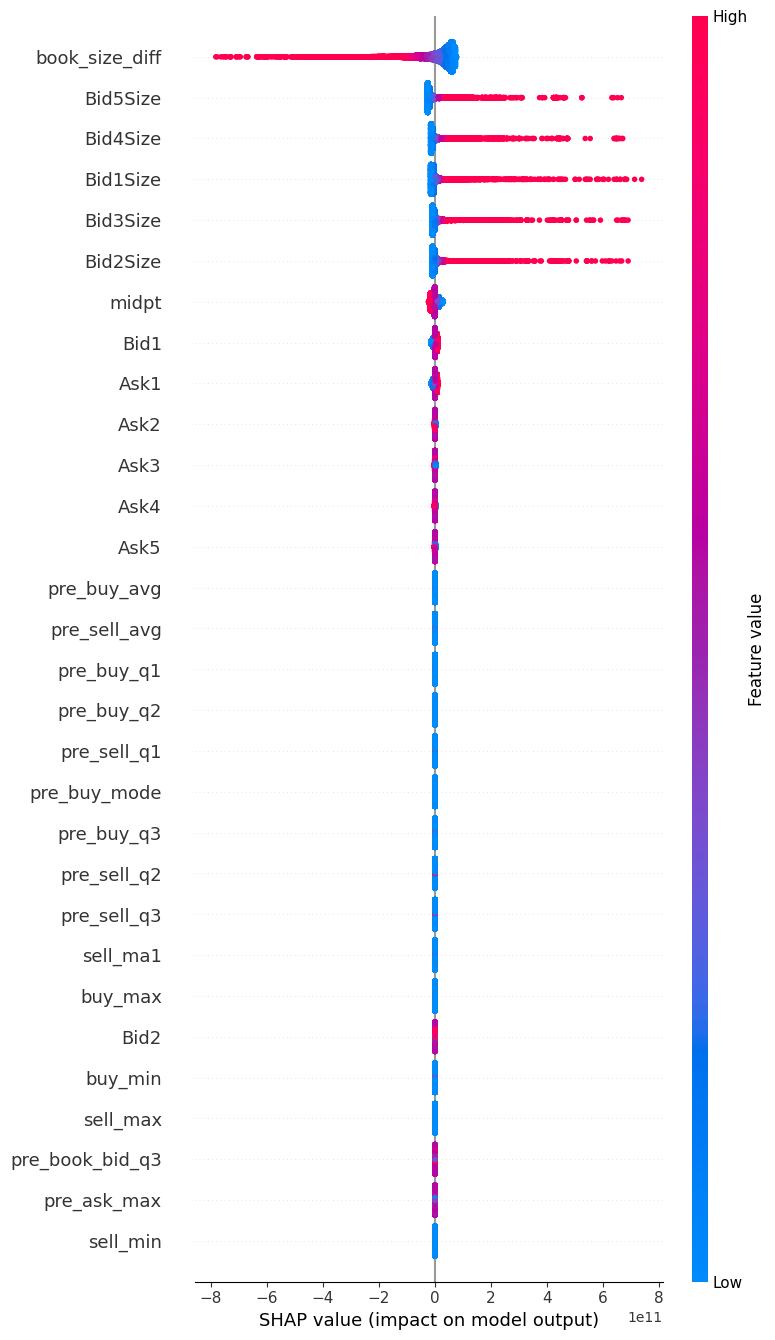

In [41]:
shap.summary_plot(explainer.shap_values(x_train), x_train, max_display=30)

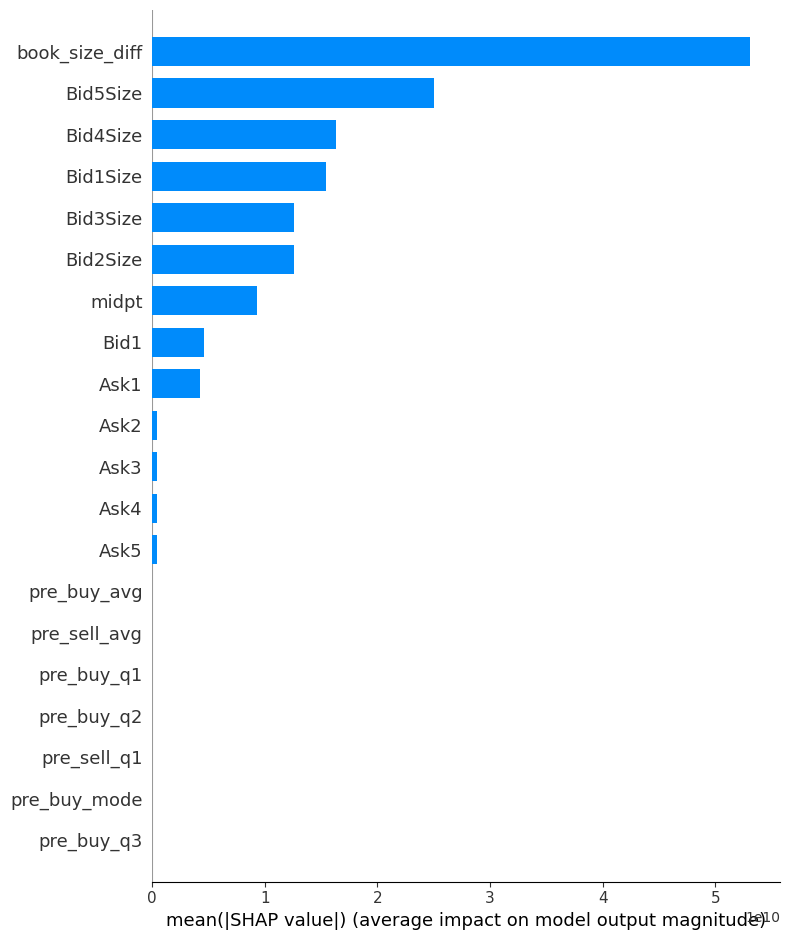

In [42]:
shap.summary_plot(explainer.shap_values(x_train), x_train, plot_type='bar', max_display=20)

In [44]:
import numpy as np
vals= np.abs(explainer.shap_values(x_train)).mean(0)
feature_importance = pd.DataFrame(list(zip(x_train.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.head(10)
feature_importance['col_name'].head(13).values

array(['book_size_diff', 'Bid5Size', 'Bid4Size', 'Bid1Size', 'Bid3Size',
       'Bid2Size', 'midpt', 'Bid1', 'Ask1', 'Ask2', 'Ask3', 'Ask4',
       'Ask5'], dtype=object)

In [57]:
# (3) RFECV
from sklearn.feature_selection import RFECV

all_features = [x for x in x_train.columns]
len(all_features)  #80

rfecv = RFECV ( estimator = LinearRegression()
                  ,step = 1
                  ,cv = 5
                  ,scoring = 'neg_root_mean_squared_error'
                 )
rfecv.fit(x_train, y_train)

print('\n Optimal number of features: %d' % rfecv.n_features_)
sel_features = [f for f, s in zip(all_features, rfecv.support_) if s]
print('\n The selected features are {}:'.format(sel_features))


 Optimal number of features: 5

 The selected features are ['midpt', 'pre_buy_q1', 'pre_buy_avg', 'pre_sell_q2', 'pre_sell_avg']:


# general CV function for feature selection

In [66]:
import numpy as np
from sklearn.model_selection import KFold
df = pd.DataFrame()
df['f1'] = [1, 2, 3, 4, 5]
df['f2'] = [1.2, 2.2, 3.2, 4.2, 5.2]
df['target'] = [1,2,3,4,5]
df.head()


,f1,f2,target
0,1,1.2,1
1,2,2.2,2
2,3,3.2,3
3,4,4.2,4
4,5,5.2,5


In [68]:
kf = KFold(n_splits=5)
use_cols = ['f1', 'f2']
X = df[use_cols].values
y = df['target'].values
for i, (train_index, test_index) in enumerate(kf.split(X)):
    print(f"Fold {i}")
    print("train_index:", train_index)
    print("test_index:", test_index)
    print('-'*10)
    print()

Fold 0
train_index: [1 2 3 4]
test_index: [0]
----------

Fold 1
train_index: [0 2 3 4]
test_index: [1]
----------

Fold 2
train_index: [0 1 3 4]
test_index: [2]
----------

Fold 3
train_index: [0 1 2 4]
test_index: [3]
----------

Fold 4
train_index: [0 1 2 3]
test_index: [4]
----------



In [69]:
train_index = np.array([1,2,3,4])
test_index = np.array([0])
model.train(X[train_index], y[train_index])
preds = model.predict(X[test_index])
rmse(y[test_index], preds)

array([[2. , 2.2],
       [3. , 3.2],
       [4. , 4.2],
       [5. , 5.2]])

In [70]:
y[arr]

array([2, 3, 4, 5], dtype=int64)

In [120]:
use_less_cols = []
for col in x_train.columns:
    if col == 'midpt':
        continue
    corr = x_train['midpt'].corr(x_train[col])
    if (corr > 0.99):
        print(col)
        use_less_cols.append(col)

Bid1
Ask1
Bid2
Ask2
Bid3
Ask3
Bid4
Ask4
Bid5
Ask5
pre_book_ask_mode
pre_book_ask_q1
pre_book_ask_q2
pre_book_ask_q3
pre_book_bid_mode
pre_book_bid_q1
pre_book_bid_q2
pre_book_bid_q3


In [144]:
# 先用所有的columns去跑5-Fold CV

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

all_cols = [x for x in x_train.columns]
print(len(all_cols))
kf = KFold(n_splits=5)
X = x_train.values
y = y_train.values

rmse_all_cols = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    reg = LinearRegression().fit(X[train_index], y[train_index])
    y_pred = reg.predict(X[test_index])
    MSE = mean_squared_error(y[test_index], y_pred)
    RMSE = math.sqrt(MSE)
    print(f"Fold {i}, Root Mean Square Error: {RMSE}")
    rmse_all_cols.append(RMSE)

80
1103.25
Fold 0, Root Mean Square Error: 1.576046541173995
1131.885
Fold 1, Root Mean Square Error: 0.21092732656829263
1147.99
Fold 2, Root Mean Square Error: 0.226359912403386
1148.68
Fold 3, Root Mean Square Error: 0.24080759239256874
1184.03
Fold 4, Root Mean Square Error: 0.25664202893490706


In [141]:
# 先用所有的columns去跑5-Fold CV

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

all_cols = [x for x in x_train.columns]
exp1_cols = [v for v in all_cols if v != 'midpt']
print(len(exp1_cols))

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')[exp1_cols]
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

kf = KFold(n_splits=5)
X = x_train.values
y = y_train.values

rmse_exp1_cols = []

for i, (train_index, test_index) in enumerate(kf.split(X)):
    reg = LinearRegression().fit(X[train_index], y[train_index])
    y_pred = reg.predict(X[test_index])
    MSE = mean_squared_error(y[test_index], y_pred)
    RMSE = math.sqrt(MSE)
    print(f"Fold {i}, Root Mean Square Error: {RMSE}")
    rmse_exp1_cols.append(RMSE)

79
Fold 0, Root Mean Square Error: 1.5760450971716573
Fold 1, Root Mean Square Error: 0.21093141964308185
Fold 2, Root Mean Square Error: 0.22636099189316955
Fold 3, Root Mean Square Error: 0.24080462334650987
Fold 4, Root Mean Square Error: 0.2566455122957694


In [149]:
values = [111,222,333,444,555]
for index, v in enumerate(values):
    print(index, v)

0 111
1 222
2 333
3 444
4 555


In [142]:
all_rmse = sum(rmse_all_cols) / 5
exp1_rmse = sum(rmse_exp1_cols) / 5
print(all_rmse)
print(exp1_rmse)

0.5021566802946299
0.5021575288700376


In [143]:
exp1_rmse / all_rmse

1.000001689861832

In [102]:
use_cols = ['midpt']

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

x_test = feature_data.query('model==0 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_test = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']

reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)


# 4.計算RMSE
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)


Root Mean Square Error: 0.26401788818622585


In [58]:
use_cols = ['midpt', 'pre_buy_q1', 'pre_buy_avg', 'pre_sell_q2', 'pre_sell_avg']

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

x_test = feature_data.query('model==0 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_test = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']

reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)


# 4.計算RMSE
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)


Root Mean Square Error: 0.2640504484790702


In [62]:
use_cols = ['midpt']

x_train = feature_data.query('model==1 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_train = feature_data.query('model==1 and nextMidpt > 0')['nextMidpt']

x_test = feature_data.query('model==0 and nextMidpt > 0').drop(columns='nextMidpt')[use_cols]
y_test = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']

reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)


# 4.計算RMSE
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)


Root Mean Square Error: 0.26401788818622585


In [65]:
y_test = feature_data.query('model==0 and nextMidpt > 0')['nextMidpt']
y_pred = feature_data.query('model==0 and nextMidpt > 0')['midpt']
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:",RMSE)

Root Mean Square Error: 0.2639377897340532
